## やりたいこと
- NS異音データを用いたデータセットの再構築
- メニューNo 1の活性化
- メニューNo 2の基礎設計(モデルの読み込み → 閾値の有無で実施可否を判定)
- 未知データに対する推論処理の基礎実験

In [1]:

"""
機械学習による異音検知スクリプト プロトタイプ2020年型
"""

#%%
# cording = UTF-8
import os,wave,re,random,copy,datetime,configparser #標準ライブラリ
import scipy,pyaudio,sklearn,joblib    #サードパーティライブラリ
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from scipy import signal as s_signal
from sklearn import decomposition
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

print ("Scipy version:{0}".format(scipy.__version__))
print ("Pyaudio version:{0}".format(pyaudio.__version__))
print ("Numpy version:{0}".format(np.__version__))
print ("Pandas version:{0}".format(pd.__version__))
print ("Scikit-Learn version:{0}".format(sklearn.__version__))
print ("Tensorflow version:{0}".format(tf.__version__))
print ("tf.keras version:{0}".format(tf.keras.__version__))
print ("joblib version:{0}".format(joblib.__version__))

###########################グローバル変数の初期値###########################

#録音関連
bitrate = pyaudio.paInt16
sr = 22050  #サンプリングレート 22050推奨
rec_length = 3
a_index = None
disp_spg = False    #録音後にスペクトラムを表示するかどうか Falseだと波形表示

#Augmentation関連
aug_amount = 512    #1ファイルごとのAugmentation回数
train_file = "train_ds.npz" #プレトレーニング用データセット
test_file = "test_ds.npz"   #テスト用データセット

#PCA関連
exp_ver = 0.999     #PCAの圧縮率(保持する分散の割合)

#パス関連
base_dir = os.path.dirname(__file__)        #スクリプトファイルの保管場所基準
data_dir = os.path.join(base_dir,"data")    #データセットの保存パス
save_dir = os.path.join(data_dir,"waves")   #録音データの保存パス
model_dir = os.path.join(base_dir,"models") #学習済みモデルの保存パス
log_dir = os.path.join(base_dir,"logs")     #ログの保存パス


#############################定義系オブジェクト#############################

#設定値の読み込み・書き出し処理
class Init_val:
    def __init__(self):
        pass

    #グローバル変数で指示されたパスがない場合に自動生成
    def path_exist(self,target_dir):
        if os.path.exists(target_dir):
            pass
        else:
            os.mkdir(target_dir)
            print("Created a directory:{0}".format(target_dir))

    #設定値のセット
    def def_ini(self,bitrate,sr,rec_length,a_index,disp_spg,aug_amount,
    exp_ver,train_file,test_file,base_dir,data_dir,save_dir,model_dir,log_dir):
        x = configparser.ConfigParser()

        x["General"] = {
            "base_dir" : base_dir,
            "data_dir" : data_dir,
            "save_dir" : save_dir,
            "model_dir" : model_dir,
            "log_dir" : log_dir
        }

        x["Rec_param"] = {
            "bitrate" : bitrate,
            "sr" : sr,
            "rec_length" : rec_length,
            "disp_spg" : disp_spg
        }

        x["Aug_param"] = {
            "aug_amount" : aug_amount,
            "train_file" : train_file,
            "test_file" : test_file
        }

        x["PCA_param"] = {
            "exp_ver" : exp_ver
        }

        #オーディオインデックスの処理 CongifparserはNoneを扱えないため空白にする
        if a_index == None:
            x["Rec_param"]["a_index"] = ""
        else:
            x["Rec_param"]["a_index"] = str(a_index)

        return x

    #iniファイルの保存
    def save_ini(self,cfg):
        with open("proto2020.ini","w") as cfgfile:
            cfg.write(cfgfile)

    #iniファイルの読み出し
    def load_ini(self):
        x = configparser.ConfigParser()
        x.read("./proto2020.ini")

        return x

    #iniインスタンスからの変数読み出し
    def set_ini(self,cfg):
        bitrate = cfg.getint("Rec_param","bitrate")
        sr = cfg.getint("Rec_param","sr")
        rec_length = cfg.getint("Rec_param","rec_length")
        disp_spg = cfg.getboolean("Rec_param","disp_spg")

        aug_amount = cfg.getint("Aug_param","aug_amount")
        train_file = cfg.get("Aug_param","train_file")
        test_file = cfg.get("Aug_param","test_file")

        exp_ver = cfg.getfloat("PCA_param","exp_ver")

        base_dir = cfg.get("General","base_dir")
        data_dir = cfg.get("General","data_dir")
        save_dir = cfg.get("General","save_dir")
        model_dir = cfg.get("General","model_dir")
        log_dir = cfg.get("General","log_dir")

        #オーディオインデックス番号の処理
        a_index = cfg.get("Rec_param","a_index")
        if a_index == "":
            a_index = None
        else:
            a_index = int(a_index)

        return bitrate,sr,rec_length,a_index,disp_spg,aug_amount,\
        exp_ver,train_file,test_file,base_dir,data_dir,save_dir,model_dir,log_dir

#オーディオインデックス定義
class Def_index:
    def __init__(self):
        pass

    #オーディオインデックスの取得
    def select_indexes(self):
        p = pyaudio.PyAudio()
        print("***List of available audio devices:***")
        for i in range(p.get_device_count()):
            print(i,p.get_device_info_by_index(i).get("name"),sep = " - ")
        x = int(input("Select Audio device Index No."))
        print("***Selected audio device #{0}.***".format(x))
        del p
        return x

#録音関連
class Elem_rec:
    def __init__(self):
        pass
    
    #録音を行う
    def proc_rec(self,bitrate,sr,rec_length,a_index):
        p = pyaudio.PyAudio()

        #ストリームの開始
        stream = p.open(format = bitrate,
                        channels = 1,   #モノラル
                        rate = sr,
                        input = True,
                        input_device_index = a_index,
                        frames_per_buffer = 1024)   #ストリームサイズ1204固定
        
        #フレームサイズごとに音声を録音
        print("Now Recording...")
        x = []
        for i in range(0,int(sr / 1024 * rec_length)):
            x.append(stream.read(1024))
        
        #ストリームを終了
        print("finished!")
        stream.stop_stream()
        stream.close()
        p.terminate()

        #リスト型になっているxをまとめる
        x = b"".join(x)

        #後処理と出力
        del p,stream
        return x

    #波形の描画
    def vis_waveform(self,waveform):
        plt.plot(waveform)
        plt.show()

    #スペクトログラムの描画(デフォルトはオフ)
    def vis_spectrogram(self,waveform,sr):
        x = np.arange(0)
        freq,time,x =s_signal.spectrogram(
            waveform,
            fs = sr,
            window = np.hamming(1024),
            nfft = 1024,
            scaling = "spectrum",
            mode = "magnitude"
        )
        del freq,time
        plt.pcolormesh(x,norm = LogNorm())
        plt.colorbar()
        plt.yscale("Log")
        plt.show()

    #Wavファイルへの書き出し
    def save_rec(self,bulkwave,save_dir,bitrate,sr):
        #ファイルネームの生成 保存時の時間で生成する
        dt = datetime.datetime.now()
        filename = dt.strftime("%Y%m%d%H%M%S") + ".wav"

        #実際の保存処理 waveオブジェクトをほぼリファレンス通りに使う
        r_path = os.getcwd()    #保存処理終了後のディレクトリ戻り先の取得
        os.chdir(save_dir)

        p = pyaudio.PyAudio()
        x = wave.open(filename,"wb")
        x.setnchannels(1)
        x.setsampwidth(p.get_sample_size(bitrate))
        x.setframerate(sr)
        x.writeframes(bulkwave)
        x.close()

        del p,x
        print("Saved! Filename:{0}".format(filename))

        #カレントディレクトリを元に戻す
        os.chdir(r_path)
        del r_path

#Augmentation関連
class Elem_aug:
    def __init__(self):
        pass

    #対象フォルダ内のWaveファイルの一覧を取得
    def wav_search(self,dir):
        #初期化
        x = []

        for i in os.listdir(dir):
            search_index = re.search(".wav",i)
            if search_index:
                x.append(i)
        print ("Files to process:{0}".format(x))

        return x

    #オーディオファイルの読み込み numpy配列として読み込む
    def load_wav(self,dir,file):
        #初期化
        x = np.arange(0)

        bulkwave = wave.open(os.path.join(dir,file),"rb").readframes(-1)
        x = np.frombuffer(
            bulkwave,dtype = "int16"
        ) / float(
            (np.power(2,16) /2) -1
        )

        del bulkwave
        return x

    #Augmentation処理 ノイズの追加
    def add_noize(self,wav):

        x = wav + np.random.randn(len(wav))*random.uniform(0,0.0001)
        return x

    #スペクトログラム取得 スペクトラムスケール・マグニチュード
    def get_spg(self,wav,sr):
        
        #初期化
        x = np.arange(0)
        freq,time,x = s_signal.spectrogram(
            wav,
            fs = sr,
            window = np.hamming(1024),
            nfft = 1024,
            scaling = "spectrum",
            mode = "magnitude"
        )
        return freq,time,x

#分類器の定義
class Elem_estimator:
    def __init__(self):
        pass

    #PCA分類器の定義と事前学習
    def est_PsdAE(self,X,exp_ver):
        #1回目の処理 指定された保持分散率に戻づく次元数を決める
        model = sklearn.decomposition.IncrementalPCA()
        model.fit(X.reshape(len(X),-1))
        n_components = np.argmax(
            np.cumsum(
                model.explained_variance_ratio_
                ) >= exp_ver
            ) +1
        
        #n_componentsが極端に少ない場合は元の次元数の1/100に制限する
        min_dim = int((X.shape[1]*X.shape[2])/100)
        if n_components < min_dim :
            n_components = min_dim
        else:
            pass

        #分散保持率と次元数をプロット
        plt.plot(np.cumsum(model.explained_variance_ratio_))
        plt.scatter(n_components,exp_ver)
        plt.xlabel("Dimensions")
        plt.ylabel("Explained Variance")
        plt.title(
            "Explained Ver:" + str(exp_ver) + \
                " -> Dimensions:" + str(n_components)
            )
        plt.show()    
 
        #2回目処理 求めた次元数の事前学習を行う
        del model
        x = sklearn.decomposition.IncrementalPCA(
            n_components = n_components
            )
        x.fit(X.reshape(len(X),-1))

        return x        

#モデル保存/ロード関連
class Elem_serialize:
    def __init__(self):
        pass

    #モデルデータと閾値のパッケージング
    def pack_model_thresh(self,model,thresh):
        x = {"model":model,"thresh":thresh}
        return x

    #joblibでの保存
    def model_save(self,obj,model_dir,modelname = "model2020.dat"):
        joblib.dump(
            obj,os.path.join(model_dir,modelname)
        )
        print("Model saved!")

    #joblibのロード
    def model_load(self,model_dir,modelname = "model2020.dat"):
        obj = joblib.load(
            os.path.join(model_dir,modelname)
        )
        print("Model loded!!")
        return obj

    #パッケージデータからモデルと閾値を取り出す
    def unpack_model_thresh(self,obj):
        model = obj["model"]
        thresh = obj["thresh"]
        return model,thresh

#判定誤差の計算
class Elem_errorcalc:
    def __init__(self):
        pass

    #元データ(X)と復元後データ(X_dec)のMSEを計算
    def calc_mse(self,X,X_dec):
        x = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            x[i] = sklearn.metrics.mean_squared_error(
                X[i],X_dec[i]
                )
        return x

    #分離境界の計算
    def calc_thresh(self,y,mse):
        x = (
            (
                (mse[y].min() - mse[np.logical_not(y)].max()) / 2
                ) + mse[np.logical_not(y)].max()
            )
        print("threshold:{}".format(x))
        return x

    #MSEと分離境界を計算する
    def calc_clf_thresh(self,X,X_dec,y):
        mse = self.calc_mse(X,X_dec)
        if mse[y].min() > mse[np.logical_not(y)].max():
            thresh = self.calc_thresh(y,mse)
        else:
            print ("Cannot define classification threshold!!")
            thresh = None

        return mse,thresh

#推論処理
class Elem_predictor:
    def __init__(self):
        pass

    #デコーダ
    def dec_PsdAE(self,X,model):      #,scaler
        x = model.inverse_transform(
            model.transform(X.reshape(len(X),-1))
        )   #次元削減して元に戻す
        x = x.reshape(len(X),X.shape[1],X.shape[2]) #形状を元に戻す
        return x
    
    #y_pred(デコーダからの推測値)の生成
    def mse_predictor(self,mse,thresh):
        x = np.zeros(len(mse),dtype=bool)
        for i in range(len(mse)):
            if mse[i] < thresh:
                x[i] = False
            else:
                x[i] = True

        return x

    #確率評価
    def eval_proba(self,y_pred,mse,thresh):
        if np.count_nonzero(y_pred)/len(y_pred) >0.5:
            result = "NG"
            print("NG(True)")
        else:
            result = "OK"
            print("OK(False)")
        print("MSE:{0},Threshold:{1}".format(
            np.mean(mse),thresh))

        #閾値と判定結果の可視化
        plt.scatter(
            np.arange(len(y_pred)),
            mse,
            color = "#ff0000",
            linestyle='None'
            )
        plt.plot(
            np.arange(
                len(y_pred)),
                np.full(len(y_pred),thresh),
                color = "#000000",
                linestyle = "--")
        plt.ylabel("MSE")
        plt.yscale("Log")
        plt.title("Result :" + str(result) + " mean MSE = " +str(np.mean(mse)))
        plt.show()



    #モデルの評価
    def model_evaluate(self,y_true,y_pred):
        print("Classification report:\n{}".format(
            sklearn.metrics.classification_report(
                y_true,y_pred
            )
        ))
        print ("Confusion Matrix:\n{}".format(
            sklearn.metrics.confusion_matrix(
                y_true,y_pred
            )
        ))    

#可視化関連
class Elem_visualizer:
    def __init__(self):
        pass
    
    #復元状況の可視化関数
    def vis_error(self,i,X,X_dec,y,y_pred,mse):
        plt.subplot(311)
        plt.pcolormesh(X[i],norm = LogNorm())   #.reshape(X_shape)
        plt.colorbar()
        plt.yscale("Log")
        plt.title("Data:" + str(y[i]))

        plt.subplot(312)
        plt.pcolormesh(X_dec[i],norm = LogNorm())
        plt.colorbar()
        plt.yscale("Log")
        plt.title("Predict:" + str(y_pred[i]))

        plt.subplot(313)
        plt.pcolormesh(np.abs(X[i]-X_dec[i]),norm = LogNorm())
        plt.colorbar()
        plt.yscale("Log")
        plt.title("MSE:" + str(mse[i]))

        plt.show()
    
    #分離境界の可視化
    def vis_mse(self,y,mse,thresh):
        plt.scatter(
            y[np.logical_not(y)],
            mse[np.logical_not(y)],
            color = "#0000ff",
            linestyle='None',
            label = "False"
            )
        plt.scatter(
            y[y],
            mse[y],
            color = "#ff0000",
            linestyle='None',
            label = "True"
            )
        plt.plot(
            np.arange(2),
            np.array([thresh,thresh]),
            color = "#000000",
            linestyle = "--"
            )
        plt.xlabel("Bool_val")
        plt.ylabel("MSE")
        plt.yscale("log")
        plt.title("Decoding error (MSE) and separation threshold")
        plt.legend()
        plt.show()

#############################処理系オブジェクト#############################

#起動処理
class Bootup(Init_val,Def_index):
    def __init__(self):
        pass

    #ワークフォルダの生成と初期設定値の記憶・読み込み
    def Bootinit(self,bitrate,sr,rec_length,a_index,disp_spg,aug_amount,
    exp_ver,train_file,test_file,base_dir,data_dir,save_dir,model_dir,log_dir):
        #データファイル関係の検索と生成
        super().path_exist(data_dir)
        super().path_exist(save_dir)
        super().path_exist(model_dir)
        super().path_exist(log_dir)
        super().path_exist(os.path.join(save_dir,"test"))
        super().path_exist(os.path.join(save_dir,"test","ok"))
        super().path_exist(os.path.join(save_dir,"test","ng"))

        #iniファイルの生成及び読み込み
        if os.path.exists("./proto2020.ini"):
            #iniファイルが存在する場合グローバル変数をiniファイル内容で上書き
            cfg = super().load_ini()
            bitrate,sr,rec_length,a_index,disp_spg,aug_amount,\
                exp_ver,train_file,test_file,base_dir,data_dir,save_dir,\
                model_dir,log_dir =super().set_ini(cfg)
            p = pyaudio.PyAudio()
            print("Loaded initial settings.\n***Audio device #{0} - {1} is selected***"\
            .format(a_index,p.get_device_info_by_index(a_index)\
                .get("name")))
            del p
        else:
            #オーディオインデックスを選択後、変数をiniファイルに格納する
            a_index = super().select_indexes()  #インデックスの選択
            cfg = super().def_ini(
                bitrate,sr,rec_length,a_index,disp_spg,aug_amount,
                exp_ver,train_file,test_file,base_dir,data_dir,save_dir,
                model_dir,log_dir)
            super().save_ini(cfg)
            print("Saved default settings: ./proto2020.ini")

        return bitrate,sr,rec_length,a_index,disp_spg,aug_amount,\
            exp_ver,train_file,test_file,base_dir,data_dir,save_dir,\
            model_dir,log_dir

#録音からセーブまでの一貫処理
class Audio_Recoder(Elem_rec):
    def __init__(self):
        pass

    def exec(self,bitrate,sr,rec_length,a_index,save_dir):
        #録音処理
        x = super().proc_rec(
            bitrate,sr,rec_length,a_index
        )

       #録音結果の表示
        form_wave = np.frombuffer(
            x,dtype="int16"
            ) / float(
                (np.power(2, 16) / 2) - 1
                )   #データ表示用にNumpy配列に変換
        if disp_spg == False:
            super().vis_waveform(form_wave)
        else:
            super().vis_spectrogram(form_wave,sr)
        del form_wave

        #セーブ
        super().save_rec(x,save_dir,bitrate,sr)

#Augmentationとデータセット作成、セーブ/ロード
class Proc_Dataset(Elem_aug):
    def __init__(self):
        pass

    #単一ファイルに対するAugmentation処理
    def proc_aug(self,wav,sr,aug_amount):
        for i in range(aug_amount):
            #ノイズの付与
            wf = super().add_noize(wav)

            #スペクトラムの取得
            freq,time,spg = super().get_spg(wf,sr)
            spg = spg.reshape(1,len(freq),len(time))    #3次元配列に変換

            #水増しされたデータを積み上げる
            try:
                x
            except:
                x = copy.deepcopy(spg)
            else:
                x = np.vstack((x,spg))

            del wf,spg,freq,time
        
        return x,i

    #データセットの生成
    def make_ds(self,dir,sr,aug_amount):
        #ウェーブリストを読み込む
        wave_list = super().wav_search(dir)
        #カウンター値のリセット
        counter = 0
        #ウェーブリストを変数としてforループを組む
        for i in wave_list:
            wav = super().load_wav(dir,i)
            auged_spg,count = self.proc_aug(wav,sr,aug_amount)
            del wav

            #データをスタック
            try:
                x
            except:
                x = copy.deepcopy(auged_spg)
            else:
                x = np.vstack((x,auged_spg))

            #カウンター
            counter = counter + (count + 1)
            print ("Augmentation count = {}".format(counter))

            del auged_spg,count

        #混ぜる
        np.random.shuffle(x)

        del counter
        return x

    #X_trainの作成
    def train_ds(self,dir,sr,aug_amount,data_dir,train_file):
        #データセットを作成 指定されたディレクトリの中身全てデータセット化
        x = self.make_ds(dir,sr,aug_amount)
        #保存する
        np.savez_compressed(os.path.join(data_dir,train_file),X = x)
        print("The traning dataset has been generated and saved.")
        print("Dataset file :{0}"\
            .format(os.path.join(data_dir,train_file)))

        return x

    #X_test,y_testの作成
    def test_ds(self,save_dir,sr,aug_amount,data_dir,test_file):

        #OKデータセットの作成
        ok_dir = os.path.join(save_dir,"test\\ok")
        X_ok = self.make_ds(ok_dir,sr,aug_amount)
        y_ok = np.zeros(len(X_ok),dtype = "bool")   #OKをFalseに定義
        #NGデータセットの作成
        ng_dir = os.path.join(save_dir,"test\\ng")
        X_ng = self.make_ds(ng_dir,sr,aug_amount)
        y_ng = np.ones(len(X_ng),dtype = "bool")   #NGをTrueに定義
        #両者をスタック
        x = np.vstack((X_ok,X_ng))
        y = np.append(y_ok,y_ng)
        del ok_dir,ng_dir,X_ok,y_ok,X_ng,y_ng

        #ランダムシード値を生成し、両者をソート
        r_seed = np.arange(x.shape[0])
        np.random.shuffle(r_seed) 
        x = x[r_seed,:]
        y = y[r_seed,]

        #保存する
        np.savez_compressed(os.path.join(data_dir,test_file),
        X = x,y = y)
        print("The test dataset has been generated and saved.")
        print("Dataset file :{0}"\
            .format(os.path.join(data_dir,test_file)))

        return x,y


    #データセットのロード(train,test 双方読み込む)
    def load_dataset(self,data_dir,train_file,test_file):
        load_0 = np.load(os.path.join(data_dir,train_file))
        X_train = load_0["X"]
        del load_0
        load_1 = np.load(os.path.join(data_dir,test_file))
        X_test = load_1["X"]
        y_test = load_1["y"]
        print("Loaded datasets.(train/test)")

        return X_train,X_test,y_test

#プレトレーニング
class Pretraining(Elem_estimator):
    def __init__(self):
        pass

    #プレトレーニング
    def pretrain(self,X_train,exp_ver):
        #モデルをインスタンス化し、X_trainで学習させる
        x = super().est_PsdAE(X_train,exp_ver)
        #次元数を表示
        print("Training is over!\n n_components = {0}"\
            .format(x.n_components_))
        
        return x
    
#テストデータによる分離境界の設定とモデルの保存
class Threh_set(Elem_errorcalc,Elem_predictor,Elem_serialize,Elem_visualizer):
    def __init__(self):
        pass

    #初期境界の計算とモデルセーブ
    def ini_thresh(self,X,y,model,model_dir):
        #テストデータをデコード
        X_dec = super().dec_PsdAE(X,model)

        #分離境界を計算 正しく閾値が計算できていれば結果を表示
        mse,thresh = super().calc_clf_thresh(X,X_dec,y)
        if thresh != None:
            super().vis_mse(y,mse,thresh)
            
            #結果を保存
            super().model_save(
                super().pack_model_thresh(model,thresh),
                model_dir
            )
        else:
            pass
        
        return thresh

#推論と判定
class Predict(Elem_predictor,Elem_rec,Proc_Dataset,Elem_errorcalc,Elem_visualizer):
    def __init__(self):
        pass

    '''以下設計中
    ・レコーディングする(elem_rec.proc_rec)
    ・レコーディングデータのコピーを作ってNumpy配列に変換
        X_Unknown = np.frombuffer(
            bulkwave,dtype = "int16"
        ) / float(
            (np.power(2,16) /2) -1
        )
    ・Augmentation処理(Proc_Dataset.proc_aug)→X_Unknownを得る
    ・X_predの取得
        X_pred = model.fit(X_Unknown)
    ・MSEを計算
        mse = Elem_errorcalc.calc_mse(X_Unknown,X_pred)
    ・y_predの生成
        y_pred = Elem.predictor.mse_predictor(mse,thresh)
    ・確率判定
    ・判定結果の可視化
    ・推論結果の評価 ※デバッグモードのみの機能にするか？
        Elem.predictor.model_evaluate


    ・思っていた判定と異なっていたら
        └まずファイルを保存する
        ・偽陽性の場合→データセットフォルダに保存
        ・偽陰性の場合→とりあえずNGフォルダに保存
    '''


###################################UI関連##################################
class Menus(Audio_Recoder,Proc_Dataset,Pretraining,Threh_set):
    def __init__(self,bitrate,sr,rec_length,a_index,disp_spg,aug_amount,
    exp_ver,train_file,test_file,base_dir,data_dir,save_dir,model_dir,log_dir):
        self.bitrate = bitrate
        self.sr = sr
        self.rec_length = rec_length
        self.a_index = a_index
        self.disp_spg = disp_spg
        self.aug_amount = aug_amount
        self.exp_ver = exp_ver
        self.train_file = train_file
        self.test_file = test_file
        self.base_dir = base_dir
        self.data_dir = data_dir
        self.save_dir = save_dir
        self.model_dir = model_dir
        self.log_dir = log_dir

    def main_manu(self):
        print("\f***Please select an operating mode***")
        print("[0]:Collect recodeing data")
        print("[1]:Pretraining or resetting the separation threshold")
        print("[2]:Conduct abnormal noise judgment")
        print("[8]:Setting")
        print("[9]:Quit")

    #メニュー0 録音モードの呼び出しと録音処理
    def m0_rec(self):
        m0_key = None
        while m0_key == None:
            m0_key = input("Do you want to record? [0:yes 1:no]")
            if m0_key == "0":
                super().exec(
                    self.bitrate,self.sr,self.rec_length,self.a_index,
                    self.save_dir
                    )
                m0_key = None
            elif m0_key =="1":
                print("Exit recording mode.")
                break
            else:
                print("\n")
                m0_key = None
        del m0_key

    #メニュー1 データセットの作成からプレトレーニング、もしくはモデルのロード
    def m1_pretraining(self):
        #第一分岐 学習済みモデルの有無確認
        if os.path.exists(os.path.join(self.model_dir,"model2020.dat")) == True:
            #モデルがある場合、更新の有無を確認する
            m1_key_model = None
            while m1_key_model == None:
                m1_key_model = input("Would you like to update the trained model? [0:yes 1:no]")
                if m1_key_model =="0" or m1_key_model=="1":
                    break  #変数だけ保持
                else:
                    print ("\n")
                    m1_key_model == None
        else:
            m1_key_model = "0"  #更新フラグを立てておく


        #第二分岐 データセットの有無判定
        if os.path.exists(os.path.join(self.data_dir,self.train_file)) == True:
            #データセットがある場合、更新の有無を確認する
            m1_key_data = None
            while m1_key_data == None:
                m1_key_data = input("Do you want to update the dataset? [0:yes 1:no]")
                if m1_key_data =="0" or m1_key_data == "1":
                    break
                else:
                    print("\n")
                    m1_key_data = None
        else:
            m1_key_data = "0"

        #処理分岐
        if m1_key_model == "0":
            if m1_key_data == "0":
                #データセットの作成
                print("Creating training dataset...")
                X_train = super().train_ds(self.save_dir,self.sr,
                self.aug_amount,self.data_dir,self.train_file)

                print("Creating test dataset...")
                X_test,y_test = super().test_ds(self.save_dir,self.sr,
                self.aug_amount,self.data_dir,self.test_file)
            else:
                #データセットの読み込み
                X_train,X_test,y_test = super().load_dataset(self.data_dir,
                self.train_file,self.test_file
                )
            #トレーニングデータの形状を取得し、データを1次元配列に成形
            #X_shape = X_train.shape[1:]
            #X_train = X_train.reshape(len(X_train),-1)
            #X_test = X_test.reshape(len(X_test),-1)
            
            #プレトレーニング
            model = super().pretrain(X_train,exp_ver)
            del X_train

            #初期境界の設定
            thresh = super().ini_thresh(X_test,y_test,model,model_dir)

        else:
            #モデルの読み込み処理
            model,thresh = super().unpack_model_thresh(
                super().model_load(model_dir))

            #X_shapeを取得するために一度X_testを読み込む
            #ld = np.load(os.path.join(data_dir,test_file))
            #X_test = ld["X"]
            #X_shape = X_test.shape[1:]
            #del ld,X_test

        return model,thresh

    def m2_judgement(self,model,thresh):
        print("やるでぇ～")



Scipy version:1.5.0
Pyaudio version:0.2.11
Numpy version:1.17.0
Pandas version:1.0.5
Scikit-Learn version:0.23.1
Tensorflow version:1.14.0
tf.keras version:2.2.4-tf
joblib version:0.16.0


Loaded initial settings.
***Audio device #1 - デスクトップ マイク (Microsoft® LifeCam  is selected***
***Please select an operating mode***
[0]:Collect recodeing data
[1]:Pretraining or resetting the separation threshold
[2]:Conduct abnormal noise judgment
[8]:Setting
[9]:Quit
Creating training dataset...
Files to process:['OK-1.wav', 'OK-2.wav', 'OK-3.wav']
Augmentation count = 1024
Augmentation count = 2048
Augmentation count = 3072
The traning dataset has been generated and saved.
Dataset file :c:\Users\amane\OneDrive\python\proto2020\bin\data\train_ds.npz
Creating test dataset...
Files to process:['OK-4.wav']
Augmentation count = 1024
Files to process:['NG-4.wav']
Augmentation count = 1024
The test dataset has been generated and saved.
Dataset file :c:\Users\amane\OneDrive\python\proto2020\bin\data\test_ds.npz


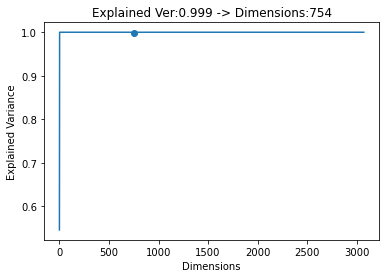

Training is over!
 n_components = 754
threshold:4.63019323256306e-06


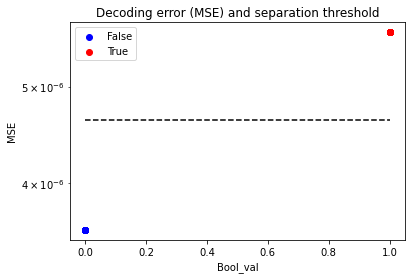

Model saved!
***Please select an operating mode***
[0]:Collect recodeing data
[1]:Pretraining or resetting the separation threshold
[2]:Conduct abnormal noise judgment
[8]:Setting
[9]:Quit

Quit.

スクリプトは正常終了しました


In [2]:
#################################メイン処理#################################

if __name__ =="__main__":
    #起動時の処理
    os.system("cls")    #画面をクリア
    os.chdir(base_dir)  #カレントディレクトリを強制指定
    x = Bootup()
    bitrate,sr,rec_length,a_index,disp_spg,aug_amount,\
    exp_ver,train_file,test_file,base_dir,data_dir,save_dir,\
    model_dir,log_dir = \
    x.Bootinit(
        bitrate,sr,rec_length,a_index,disp_spg,aug_amount,\
        exp_ver,train_file,test_file,base_dir,data_dir,save_dir,\
        model_dir,log_dir)
    del x

    #メインメニュー表示
    m_menu = Menus(
        bitrate,sr,rec_length,a_index,disp_spg,aug_amount,
    exp_ver,train_file,test_file,base_dir,data_dir,save_dir,
    model_dir,log_dir)
    valid_keys = ("0","1","2","8") #Quit以外の有効なメニュー番号
    u_const_keys = ("8")    #工事中のメニュー番号
    main_key = None
    while main_key == None:
        m_menu.main_manu()
        main_key = input("Select an operating mode:")
        #録音モード
        if main_key =="0":
            m_menu.m0_rec()
            main_key = None

        elif main_key == "1":
            model,thresh = m_menu.m1_pretraining()
            main_key = None

        elif main_key == "2":
            #モデルの有無による事前処理
            try:
                model
            except:
                model,thresh = m_menu.m1_pretraining()
                m2_key = 0
            else:
                if thresh == None:
                    m2_key = 1
                else:
                    m2_key = 0
            
            if m2_key == 0:
                m_menu.m2_judgement(model,thresh)
            else:
                print ("Inference cannot be performed because there is no threshold. \nPlease try the pre-training again")
            del m2_key
            main_key = None

        elif main_key in u_const_keys:  #未実装機能に対して工事中表示をする
            print("\nSorry,Cullenly under construction.\n")
            main_key = None
        elif main_key == "9":
            #del m_menu             #デバッグ用にコメントアウトしておく
            print("\nQuit.\n")
            break
        else:    #定義されてないキーの処理
            print("\n")
            main_key = None
        
    print("スクリプトは正常終了しました")


元のNS異音データを使用したらちゃんと分離境界が形成できた  
時間軸方向の変化には弱いのか？

In [5]:
valid_wav = m_menu.load_wav("C:\\Users\\amane\\OneDrive\\python\\proto2020\\bin\\data\\waves\\test\\varid","OK-5.wav")
X_unknown,count = m_menu.proc_aug(valid_wav,sr,aug_amount)
del valid_wav,count
X_pred = m_menu.dec_PsdAE(X_unknown,model)
mse = m_menu.calc_mse(X_unknown,X_pred)
y_pred = m_menu.mse_predictor(mse,thresh)

In [6]:
#間違っちゃいなかったがAugmentationの回数が多すぎたのでもう1回
del X_unknown,X_pred,y_pred
valid_wav = m_menu.load_wav("C:\\Users\\amane\\OneDrive\\python\\proto2020\\bin\\data\\waves\\test\\varid","OK-5.wav")
X_unknown,count = m_menu.proc_aug(valid_wav,sr,100)
del valid_wav,count
X_pred = m_menu.dec_PsdAE(X_unknown,model)
mse = m_menu.calc_mse(X_unknown,X_pred)
y_pred = m_menu.mse_predictor(mse,thresh)

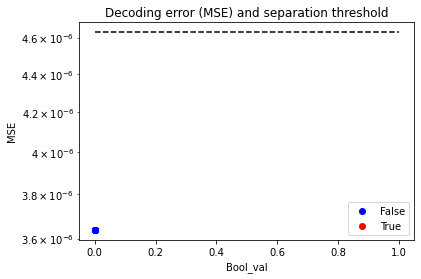

In [16]:
#一足先に推論結果の可視化をする
m_menu.vis_mse(y_pred,mse,thresh)

In [18]:
#確率判定
if np.count_nonzero(y_pred)/len(y_pred) >0.5:
    print("NG(True)")
else:
    print("OK(False)")
print("MSE:{0},Threshold:{1}".format(
    np.mean(mse),
    thresh
))

OK(False)
MSE:3.638115508307983e-06,Threshold:4.63019323256306e-06


未知データに対する推論処理ができた。mseは比較的安定している (Augmentationが弱い？)

NG(True)
MSE:6.309714608401701e-06,Threshold:4.63019323256306e-06


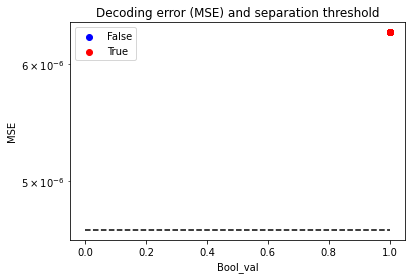

In [19]:
#ここまでをまとめて、NGデータでやってみる
del X_unknown,X_pred,y_pred
valid_wav = m_menu.load_wav("C:\\Users\\amane\\OneDrive\\python\\proto2020\\bin\\data\\waves\\test\\varid","NG-5.wav")
X_unknown,count = m_menu.proc_aug(valid_wav,sr,100)
del valid_wav,count
X_pred = m_menu.dec_PsdAE(X_unknown,model)
mse = m_menu.calc_mse(X_unknown,X_pred)
y_pred = m_menu.mse_predictor(mse,thresh)
if np.count_nonzero(y_pred)/len(y_pred) >0.5:
    print("NG(True)")
else:
    print("OK(False)")
print("MSE:{0},Threshold:{1}".format(
    np.mean(mse),
    thresh
))
m_menu.vis_mse(y_pred,mse,thresh)

未知NGデータでも安定して判定できた

## わかったこと
- 周波数変動にはめっぽう強いらしい
- 時間軸変動は弱いかもしれない
- 突発音は未知数。 実データを使ってみないと何とも言えない

## 次にやること
- 今回の推論処理のクラス実装
- メニュー2の実装 ↑のクラスを呼び出すだけではあるが…
- OKとNGの判定結果の表示がきわめてショボいので何か考える GIFでも出すか？